In [72]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from pymc.math import exp
import pytensor.tensor as at

### Question 1

#### Part 1

In [73]:
data = pd.read_csv("ortho-2.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          108 non-null    float64
 1   age        108 non-null    int64  
 2   Subject    108 non-null    object 
 3   Sex        108 non-null    object 
 4   Sex_coded  108 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.3+ KB


In [74]:
# The following code is adapted from Unit 7.19 Paraguay Vaccination Status by Aaron Reding
y = data["y"].to_numpy()
subjects = data["Subject"].to_numpy()
X = data[["age", "Sex_coded"]].to_numpy()
X_aug = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
cols = X_aug.shape[1]
y.shape, subjects.shape, X_aug.shape

((108,), (108,), (108, 3))

In [75]:
# Set up alternate coordinates
subject_idx, subjects = pd.factorize(data.Subject)
coords = {"subject": subjects, "id": data.index.to_numpy()}
coords

{'subject': Index(['M01', 'M02', 'M03', 'M04', 'M05', 'M06', 'M07', 'M08', 'M09', 'M10',
        'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'F01', 'F02', 'F03', 'F04',
        'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11'],
       dtype='object'),
 'id': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107], dtype=int64)}

In [76]:
with pm.Model(coords=coords) as m:
    X_data = pm.Data("X_data", X_aug)
    y_data = pm.Data("y_data", y)
    subject_idx = pm.Data("subject_idx", subject_idx, dims="id")

    subject_tau = pm.Gamma("subject_tau", 0.01, 0.01)
    like_tau = pm.Gamma("like_tau", 0.01, 0.01)

    subject_variance = pm.Deterministic("subject_variance", 1 / subject_tau)
    like_variance = pm.Deterministic("like_variance", 1 / like_tau)
    beta = pm.Normal("beta", mu=0, sigma=10**4, shape=cols)

    subject_effect = pm.Normal("subject_effect", mu=0, tau=subject_tau, dims="subject")

    mu = pm.math.dot(X_data, beta) + subject_effect[subject_idx]

    rho = pm.Deterministic("rho", subject_variance / (subject_variance + like_variance))

    pm.Normal("likelihood", mu=mu, sigma=pm.math.sqrt(like_variance), observed=y)

    trace_with_effects = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [subject_tau, like_tau, beta, subject_effect]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 55 seconds.


In [77]:
az.summary(
    trace_with_effects,
    var_names=["beta", "subject_variance", "like_variance", "rho"],
    filter_vars="like",
    kind="stats",
)

,mean,sd,hdi_3%,hdi_97%
beta[0],16.544,0.784,15.028,18.006
beta[1],0.660,0.062,0.545,0.780
beta[2],1.160,0.394,0.404,1.899
subject_variance,3.519,1.243,1.487,5.722
like_variance,2.110,0.342,1.509,2.755
rho,0.611,0.088,0.448,0.777


array([<Axes: title={'center': 'subject_variance'}>,
       <Axes: title={'center': 'like_variance'}>], dtype=object)

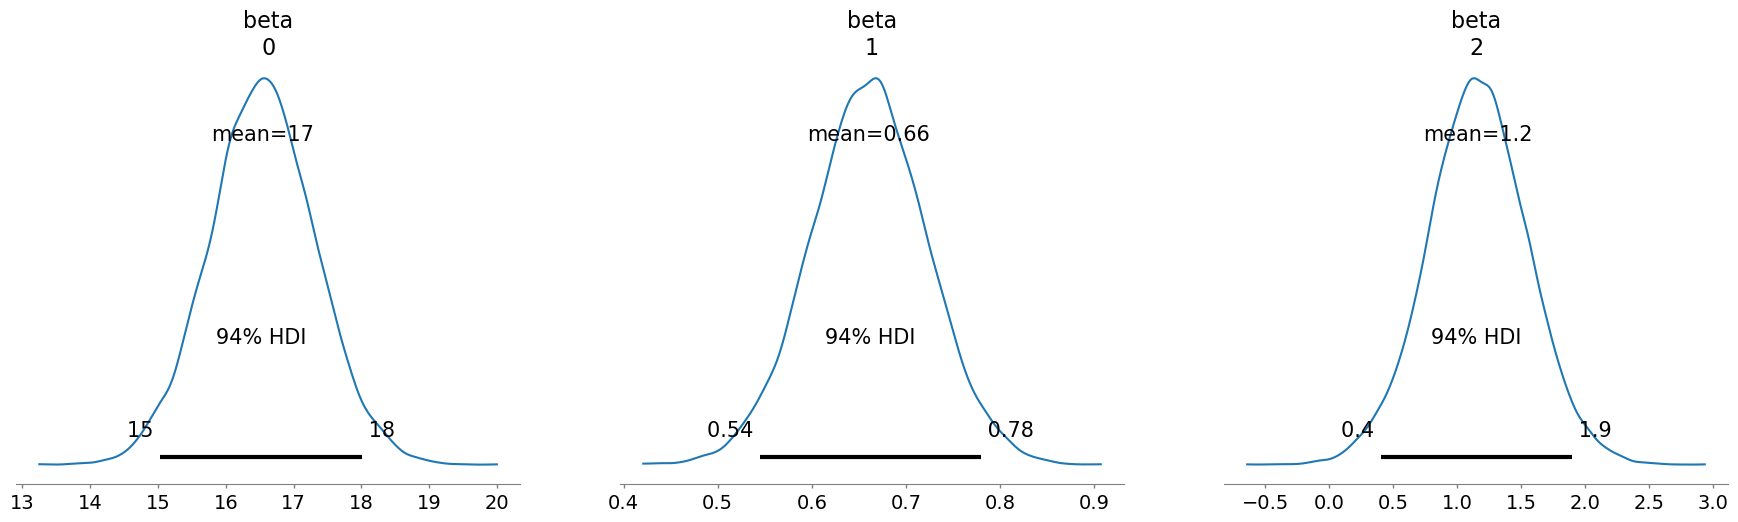

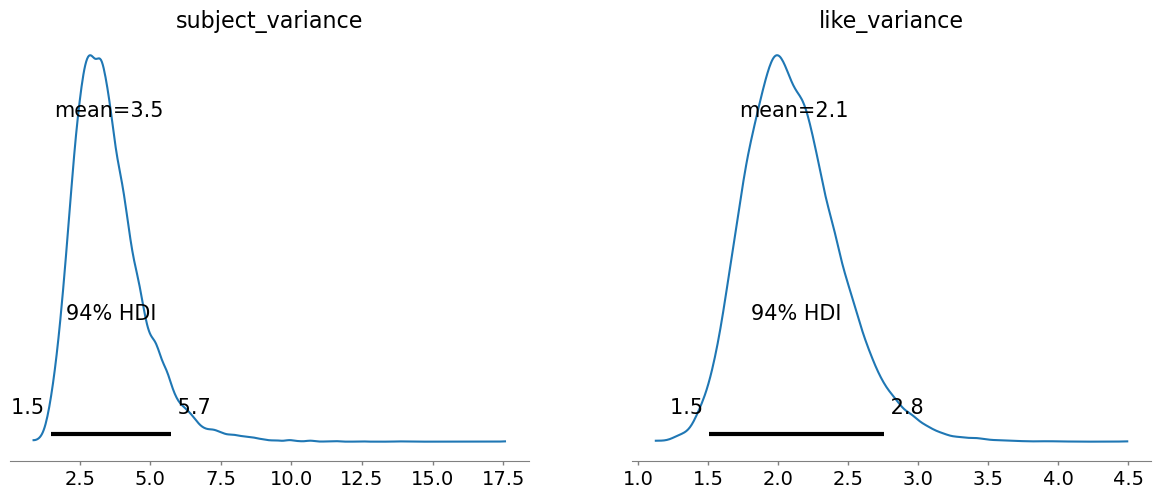

In [ ]:
az.plot_posterior(trace_with_effects, var_names=["beta"])
az.plot_posterior(trace_with_effects, var_names=["subject_variance", "like_variance"])

#### Part 2

<Axes: title={'center': 'rho'}>

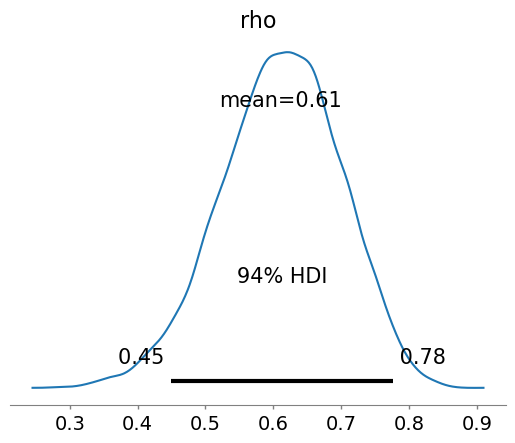

In [79]:
az.plot_posterior(trace_with_effects, var_names=["rho"])

#### Part 3

In [80]:
with pm.Model(coords=coords) as m:
    X_data = pm.Data("X_data", X_aug)
    y_data = pm.Data("y_data", y)

    like_tau = pm.Gamma("like_tau", 0.01, 0.01)

    like_variance = pm.Deterministic("like_variance", 1 / like_tau)
    beta = pm.Normal("beta", mu=0, sigma=10**4, shape=cols)

    mu = pm.math.dot(X_data, beta)

    pm.Normal("likelihood", mu=mu, sigma=pm.math.sqrt(like_variance), observed=y)

    trace_wo_effects = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [like_tau, beta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.


In [81]:
az.summary(
    trace_wo_effects,
    var_names=["beta", "like_variance"],
    filter_vars="like",
    kind="stats",
)

,mean,sd,hdi_3%,hdi_97%
beta[0],16.564,1.125,14.425,18.682
beta[1],0.659,0.100,0.469,0.849
beta[2],1.159,0.226,0.740,1.587
like_variance,5.263,0.731,3.992,6.677


<Axes: title={'center': 'like_variance'}>

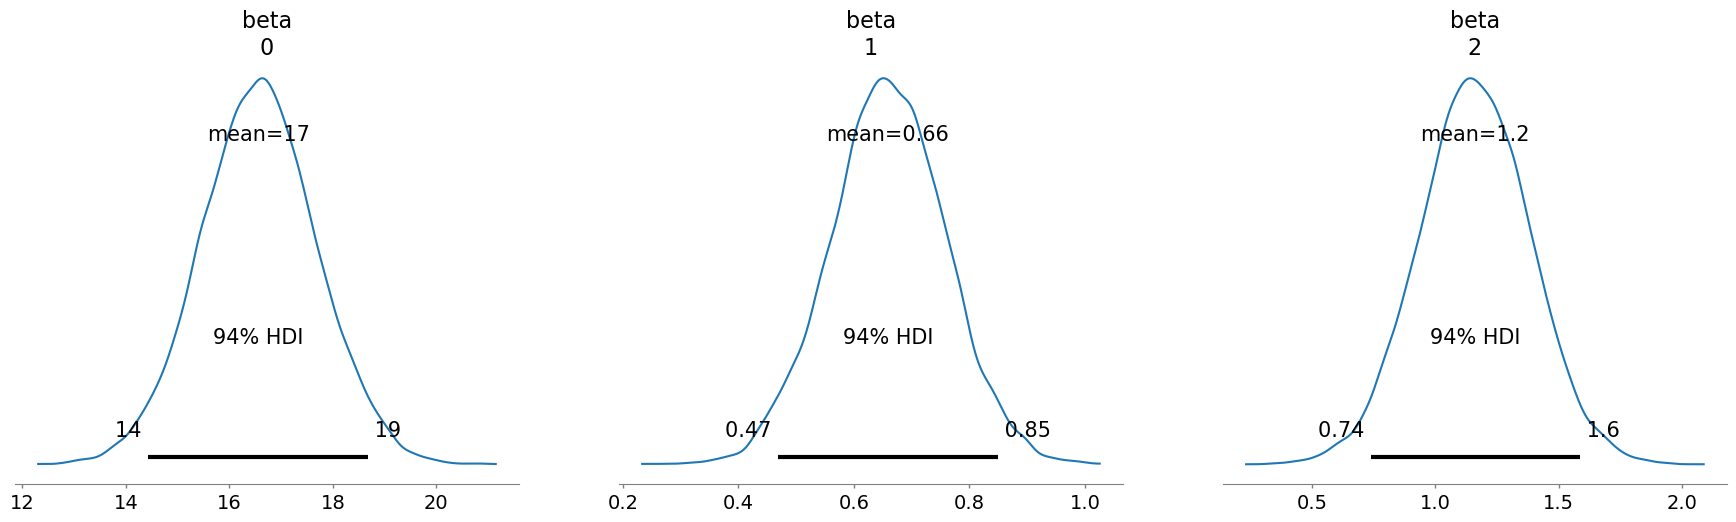

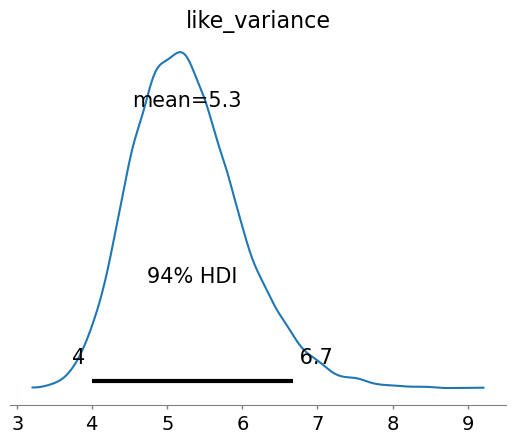

In [82]:
az.plot_posterior(trace_wo_effects, var_names=["beta"])
az.plot_posterior(trace_wo_effects, var_names=["like_variance"])

### Question 2

#### Part 1

In [95]:
data = pd.read_csv("gala-1-1.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  30 non-null     object 
 1   Species     30 non-null     int64  
 2   Area        30 non-null     float64
 3   Elevation   24 non-null     float64
 4   Nearest     30 non-null     float64
 5   Scruz       30 non-null     float64
 6   Adjacent    30 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.8+ KB


In [96]:
means = data[["Area", "Elevation", "Nearest", "Scruz", "Adjacent"]].mean()
stds = data[["Area", "Elevation", "Nearest", "Scruz", "Adjacent"]].std()

means

Area         261.708667
Elevation    424.458333
Nearest       10.060000
Scruz         56.976667
Adjacent     261.098333
dtype: float64

In [97]:
x_miss = data["Elevation"].to_numpy()
x_miss

array([  nan,  109.,  114.,   46.,   nan,   nan,   93.,  168.,   nan,
        112.,  198., 1494.,   49.,  227.,   76., 1707.,  343.,   25.,
        777.,  458.,   nan,  367.,  716.,  906.,  864.,  259.,  640.,
         nan,  186.,  253.])

In [ ]:
# The following code is adapted from Unit 8.2 Rats Example with Missing Data by Aaron Reding
with pm.Model() as poisson_no_re:
    species = pm.Data("species", data["Species"].to_numpy(), mutable=False)
    area = pm.Data("area", (data["Area"] - means["Area"]) / stds["Area"], mutable=True)
    nearest = pm.Data(
        "nearest", (data["Nearest"] - means["Nearest"]) / stds["Nearest"], mutable=True
    )
    scruz = pm.Data(
        "scruz", (data["Scruz"] - means["Scruz"]) / stds["Scruz"], mutable=True
    )
    adjacent = pm.Data(
        "adjacent",
        (data["Adjacent"] - means["Adjacent"]) / stds["Adjacent"],
        mutable=True,
    )

    beta0 = pm.Normal("beta0_intercept", mu=0, tau=0.0001)
    beta1 = pm.Normal("beta1_area", mu=0, tau=0.0001)
    beta2 = pm.Normal("beta2_elevation", mu=0, tau=0.0001)
    beta3 = pm.Normal("beta3_nearest", mu=0, tau=0.0001)
    beta4 = pm.Normal("beta4_scruz", mu=0, tau=0.0001)
    beta5 = pm.Normal("beta4_adjacent", mu=0, tau=0.0001)

    # Impute missing elevation data
    elevation_imputed = pm.Exponential(
        "elevation_imputed", lam=1 / 425, observed=x_miss
    )

    # Standardize elevation data
    elevation_mean = at.mean(elevation_imputed)
    elevation_std = at.std(elevation_imputed)
    elevation_standard = (elevation_imputed - elevation_mean) / elevation_std

    mu = pm.math.exp(
        beta0
        + beta1 * area
        + beta2 * elevation_standard
        + beta3 * nearest
        + beta4 * scruz
        + beta5 * adjacent
    )

    y = pm.Poisson("likelihood", mu=mu, observed=species)

    trace_poisson_no_re = pm.sample(5000, init="adapt_diag")

c:\Users\jm121\Bayes\Lib\site-packages\pymc\data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
c:\Users\jm121\Bayes\Lib\site-packages\pymc\model\core.py:1359: ImputationWarning: Data in elevation_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0_intercept, beta1_area, beta2_elevation, beta3_nearest, beta4_scruz, beta4_adjacent, elevation_imputed_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 48 seconds.


In [99]:
az.summary(trace_poisson_no_re, var_names=["beta"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_intercept,3.887,0.030,3.828,3.943,0.0,0.0,12722.0,13883.0,1.0
beta1_area,-0.494,0.022,-0.536,-0.452,0.0,0.0,12059.0,12889.0,1.0
beta2_elevation,1.463,0.036,1.397,1.532,0.0,0.0,10381.0,11917.0,1.0
beta3_nearest,0.127,0.026,0.077,0.176,0.0,0.0,14183.0,14123.0,1.0
beta4_scruz,-0.424,0.043,-0.504,-0.342,0.0,0.0,13542.0,14032.0,1.0
beta4_adjacent,-0.561,0.025,-0.609,-0.514,0.0,0.0,14776.0,14487.0,1.0


#### Part 2
Please see the accompanying report for the conclusion on which variable(s) is/are considered to be significant.

### Question 3

#### Part 1

In [88]:
data = pd.read_csv("bladderc-2.csv")
data.head()

,time,observed,group
0,1,0,0
1,4,0,0
2,7,0,0
3,10,0,0
4,6,1,0


In [89]:
pd.set_option("display.max_rows", None)

In [ ]:
x = data["group"].copy()
observed = data["observed"].copy()
y = data["time"].copy()
censored = np.where(observed == 0, y, 0).astype(float)
censored[censored == 0] = np.inf

In [ ]:
# The following code is adapted from Unit 8.6 Time-to-event Models: Gastric Cancer
with pm.Model() as m:
    beta0_intercept = pm.Normal("beta0_intercept", 0, tau=0.01)
    beta1_treatment = pm.Normal("beta1_treatment", 0, tau=0.1)

    lamb = exp(beta0_intercept + beta1_treatment * x)

    obs_latent = pm.Exponential.dist(lam=lamb)

    likelihood = pm.Censored(
        "likelihood", obs_latent, lower=None, upper=censored, observed=y
    )

    mu0 = pm.Deterministic("mu0", exp(-beta0_intercept))
    mu1 = pm.Deterministic("mu1", exp(-beta0_intercept - beta1_treatment))
    mu_diff = pm.Deterministic("mu_diff", mu1 - mu0)

    trace = pm.sample(
        10000,
        tune=2000,
        init="jitter+adapt_diag_grad",
        target_accept=0.9,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0_intercept, beta1_treatment]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 33 seconds.


In [92]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_intercept,-3.282,0.187,-3.671,-2.938,0.002,0.001,13564.0,18354.0,1.0
beta1_treatment,-0.533,0.301,-1.108,0.065,0.003,0.002,13872.0,19089.0,1.0
mu0,27.112,5.208,17.854,37.587,0.046,0.033,13564.0,18354.0,1.0
mu1,46.706,11.593,27.255,69.861,0.070,0.052,29218.0,26413.0,1.0
mu_diff,19.594,12.670,-3.108,45.531,0.097,0.069,16392.0,19541.0,1.0


#### Part 2

In [ ]:
mu_diff_samples = trace.posterior["mu_diff"].values.flatten()
posterior_prob_mu1_greater_mu0 = (mu_diff_samples > 0).mean()
posterior_prob_mu1_greater_mu0

0.9647

#### Part 3
Please see the accompanying report for the comment on the benefits of the treatment.